In [28]:
# py27 compatability
from __future__ import print_function
from __future__ import division
# load packages
import numpy as np                                          # advanced array functions
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
# configure matplotlib
%matplotlib inline
import seaborn as sns                                       # statistics / plotting
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm                                       # progress bar
import sspals
from mc_positronium import *

In [29]:
class Grid(object):
    """ simulate interaction with the surroundings
    """
    def __init__(self, distance=0.01):
        self.distance = distance

    def tof(self, df):
        """ find the time it takes each atom to hit the grid
        """
        tof = self.distance / df['vz']
        return tof

    def hit(self, df, eff=0.1, eff_ryd=1.0, status='grid'):
        """ modify df to include collisions with the wall
        """
        df = df.copy()
        num = len(df.index)
        # find which hit the grid
        hit_grid = df[(df.status == 'oPs') & (df['z'] > self.distance) & (np.random.random(num) < eff)].index
        hit_grid = hit_grid.append(df[(df.status == 'Rydberg') & (df['z'] > self.distance) & (np.random.random(num) < eff_ryd)].index)
        #update
        df.loc[hit_grid, 'status'] = status
        df.loc[hit_grid, 'life'] = self.tof(df.loc[hit_grid])
        df.loc[hit_grid, 'time of death'] = df.loc[hit_grid, 't0'] + df.loc[hit_grid, 'life']
        # update final position
        df.loc[hit_grid] = update_df(df.loc[hit_grid])
        return  df

In [30]:
# simulate Ps converter
num = 1e6
background = Ps_converter(num, T=600)
# transition via n=2
lyman_a = Spectroscopy(lambda_0=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
ol_threshold = 0.0005
# laser on
laser0 = Laser(wavelength=243.0e-9, trigger=1.5e-8, height=0.008)
signal0 = lyman_a.rydberg(background, laser0, ol_threshold, ex_eff=0.5, life_ryd=2e-6)
# geometry
grid = Grid(distance=0.007)
chamber = Tube(radius=0.02)

In [31]:
# fraction of Rydbergs
num_oPs = len(signal0[signal0['status'] == 'oPs'].index)
num_Ryd = len(signal0[signal0['status'] == 'Rydberg'].index)
num_Ryd / (num_oPs + num_Ryd)

0.13208903801791547

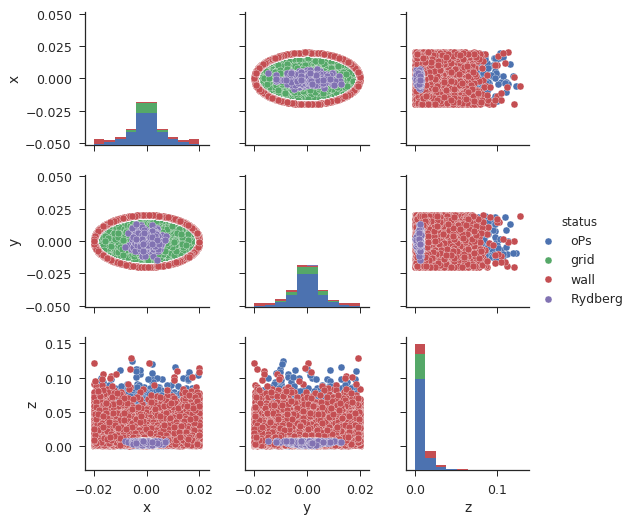

In [32]:
df = chamber.hit(grid.hit(signal0))
sns.pairplot(df[df['status'] != 'direct'], hue='status', vars=['x', 'y', 'z'])
plt.show()

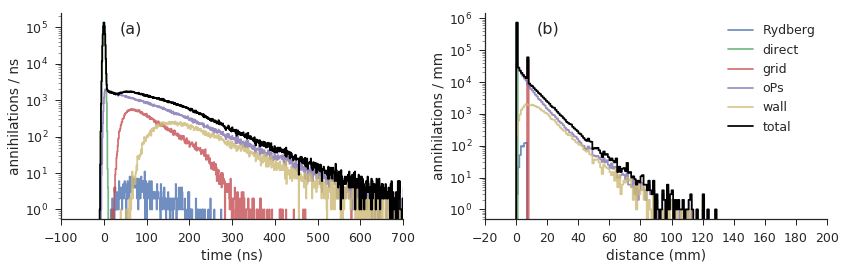

In [33]:
death = np.unique(df.status) # how many ways to die?

## plotting ##
fig, ax = plt.subplots(1,2, figsize=(12,4))

## lifetime ##
# components
for d in death:
    x1, y1 = tbin(df[df['status'] == d])
    ax[0].step(x1*1e9, y1, where='mid', label=d, alpha=0.8)
# total
x1, y1 = tbin(df)
# format
ax[0].step(x1*1e9, y1, where='mid', c='k', label='total')
ax[0].set_yscale('log')
ax[0].set_xlim(-100, 700)
ax[0].set_ylabel("annihilations / ns")
ax[0].set_xlabel("time (ns)")

## position ##
# components
for d in death:
    x2, y2 = pbin(df[df['status'] == d])
    ax[1].step(x2*1e3, y2, where='mid', label=d, alpha=0.8)
# total
x2, y2 = pbin(df)
# format
ax[1].set_ylabel("annihilations / mm")
ax[1].set_xlabel("distance (mm)")
ax[1].step(x2*1e3, y2, where='mid', c='k', label='total')
ax[1].set_xlim(-20, 200)
ax[1].set_yscale('log')
ax[1].set_xticks([-20, 0, 20, 40, 60, 80, 100, 120 ,140, 160, 180, 200])
sns.despine()

# labels
ax[0].annotate('(a)', xy=(0.17, 0.9), xycoords='axes fraction', fontsize=16)
ax[1].annotate('(b)', xy=(0.15, 0.9), xycoords='axes fraction', fontsize=16)
ax[1].legend(loc=0)

#output
plt.tight_layout()
#plt.savefig("../images/mc_ryd_parts.pdf", dpi=200, bbox_inches='tight')
plt.show()

In [34]:
limits = [-1.0E-8, 3.5e-8, 7e-7]
# SSPALS spectrum
off = chamber.hit(grid.hit(background))
on  = chamber.hit(grid.hit(signal0))

# convolve
dt = 1e-9
bins = np.arange(-5e-8, 8e-7, dt)
pwo = detector(np.arange(-1e-8, 2e-7, dt), 1e-8)
lt_off = np.histogram(off['time of death'].values, bins=bins, density=False)[0] 
#                     weights=solid_angle(off['z'], 0.04))[0]
spectra_off = np.convolve(lt_off, pwo) *1e-14
lt_0 = np.histogram(on['time of death'].values, bins=bins, density=False)[0]
#                    weights=solid_angle(on['z'], 0.04))[0]
spectra_0 = np.convolve(lt_0, pwo) *1e-14

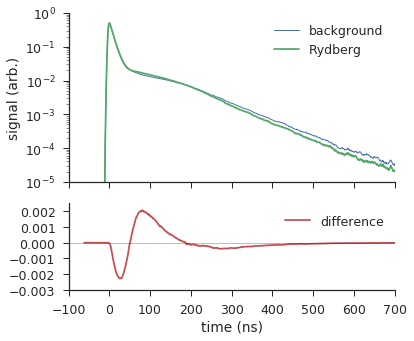

In [37]:
# plot setup
fig, ax = plt.subplots(figsize=(6,5))

# background subtraction subplot
divider = make_axes_locatable(ax)
axx = divider.append_axes("bottom", size=1.2, pad=0.3, sharex=ax)

# background
x_vals = np.arange(len(spectra_0)) * dt
ax.plot(x_vals * 1e9 - 62, spectra_off, lw=1, label='background')
# signal 0
ax.plot(x_vals * 1e9 -62, spectra_0, label='Rydberg')
axx.plot(x_vals * 1e9 -62, spectra_0 - spectra_off, c=sns.color_palette()[2], label='difference')

#format
ax.legend(loc=0)
axx.legend(loc=0)
ax.set_yscale('log')
ax.set_ylabel("signal (arb.)")
axx.set_xlabel("time (ns)")
ax.set_ylim(1e-5, 1)
ax.set_xlim(-100, 700)
sns.despine()
plt.setp(ax.get_xticklabels(), visible=False)
axx.set_ylim(-0.001, 0.0025)
axx.set_yticks([-0.003, -0.002, -0.001, 0.0, 0.001, 0.002])
axx.axhline(0, color='k', lw=0.5, alpha=0.5)

#output
plt.tight_layout()
#plt.savefig("../images/mc_rydberg.pdf", dpi=200, bbox_inches='tight')
plt.show()

In [36]:
# S_gamma
limits = [-1.0E-8, 2.5e-7, 7e-7]
fb = sspals.sspals_1D(spectra_off, dt, limits=limits)['DF'][0]
fd = sspals.sspals_1D(spectra_0, dt, limits=limits)['DF'][0]
sspals.signal(fd, 0, fb, 0)[0]

16.800523789648167